# Setup
1. In colab: Go to "Runtime" -> "Change runtime type" -> Select "T4 GPU".
2. Install TerraTorch and others dependencies.

In [16]:
!pip uninstall -y terratorch
!pip install git+https://github.com/IBM/terratorch gdown tensorboard &> install.log

Found existing installation: terratorch 1.0
Uninstalling terratorch-1.0:
  Successfully uninstalled terratorch-1.0


In [1]:
import os
import sys
import torch
import gdown
import terratorch
import albumentations
import lightning.pytorch as pl
import matplotlib.pyplot as plt
from pathlib import Path
from terratorch.datamodules import GenericNonGeoSegmentationDataModule
import warnings

warnings.filterwarnings('ignore')

3. Download the dataset from Google Drive

In [2]:
if not os.path.isfile('hls_burn_scars.tar.gz'):
    gdown.download("https://drive.google.com/uc?id=1yFDNlGqGPxkc9lh9l1O70TuejXAQYYtC")

if not os.path.isdir('hls_burn_scars/'):
    !tar -xzvf hls_burn_scars.tar.gz &> tar.log


## HLS Burn Scars Dataset

Lets start with analyzing the dataset

In [3]:
dataset_path = Path('hls_burn_scars')
!ls "hls_burn_scars/"

data  splits


In [4]:
!ls "hls_burn_scars/data/" | head

subsetted_512x512_HLS.S30.T10SDH.2020248.v1.4.mask.tif
subsetted_512x512_HLS.S30.T10SDH.2020248.v1.4_merged.tif
subsetted_512x512_HLS.S30.T10SEH.2018190.v1.4.mask.tif
subsetted_512x512_HLS.S30.T10SEH.2018190.v1.4_merged.tif
subsetted_512x512_HLS.S30.T10SEH.2018245.v1.4.mask.tif
subsetted_512x512_HLS.S30.T10SEH.2018245.v1.4_merged.tif
subsetted_512x512_HLS.S30.T10SEH.2018280.v1.4.mask.tif
subsetted_512x512_HLS.S30.T10SEH.2018280.v1.4_merged.tif
subsetted_512x512_HLS.S30.T10SEH.2019305.v1.4.mask.tif
subsetted_512x512_HLS.S30.T10SEH.2019305.v1.4_merged.tif


In [5]:
datamodule = terratorch.datamodules.GenericNonGeoSegmentationDataModule(
    batch_size=4,
    num_workers=2,
    num_classes=2,

    # Define dataset paths
    train_data_root=dataset_path / 'data/',
    train_label_data_root=dataset_path / 'data/',
    val_data_root=dataset_path / 'data/',
    val_label_data_root=dataset_path / 'data/',
    test_data_root=dataset_path / 'data/',
    test_label_data_root=dataset_path / 'data/',

    # Define splits
    train_split=dataset_path / 'splits/train.txt',
    val_split=dataset_path / 'splits/val.txt',
    test_split=dataset_path / 'splits/test.txt',

    img_grep='*_merged.tif',
    label_grep='*.mask.tif',

    train_transform=[
        albumentations.D4(), # Random flips and rotation
        albumentations.pytorch.transforms.ToTensorV2(),
    ],
    val_transform=None,  # Using ToTensor() by default
    test_transform=None,

    # Define standardization values
    means=[
      0.0333497067415863,
      0.0570118552053618,
      0.0588974813200132,
      0.2323245113436119,
      0.1972854853760658,
      0.1194491422518656,
    ],
    stds=[
      0.0226913556882377,
      0.0268075602230702,
      0.0400410984436278,
      0.0779173242367269,
      0.0870873883814014,
      0.0724197947743781,
    ],
    no_data_replace=0,
    no_label_replace=-1,
    # We use all six bands of the data, so we don't need to define dataset_bands and output_bands.
)

# Setup train and val datasets
datamodule.setup("fit")

In [6]:
# checking datasets train split size
train_dataset = datamodule.train_dataset
len(train_dataset)

524

In [7]:
# checking datasets validation split size
val_dataset = datamodule.val_dataset
len(val_dataset)

160

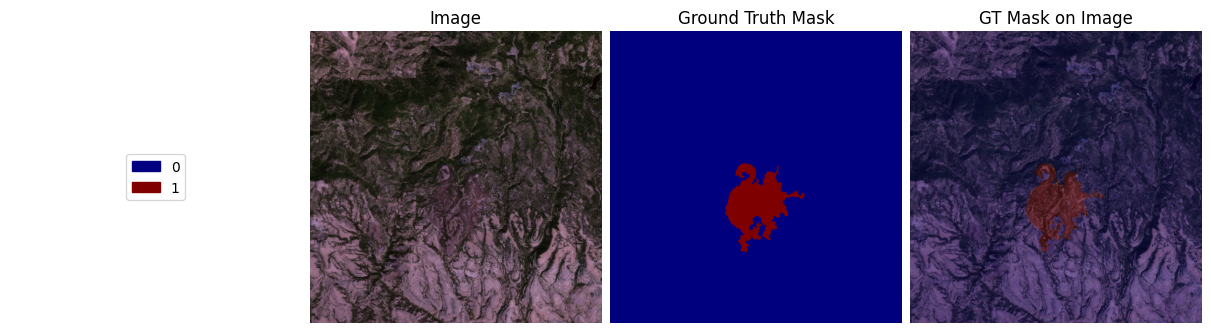

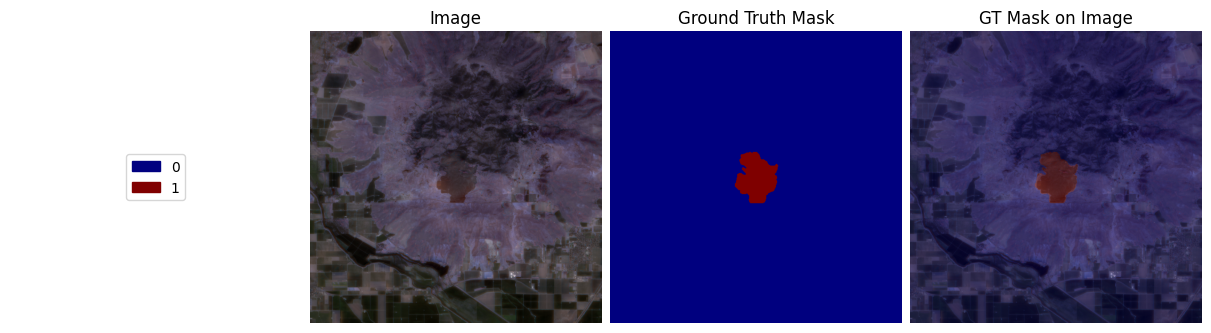

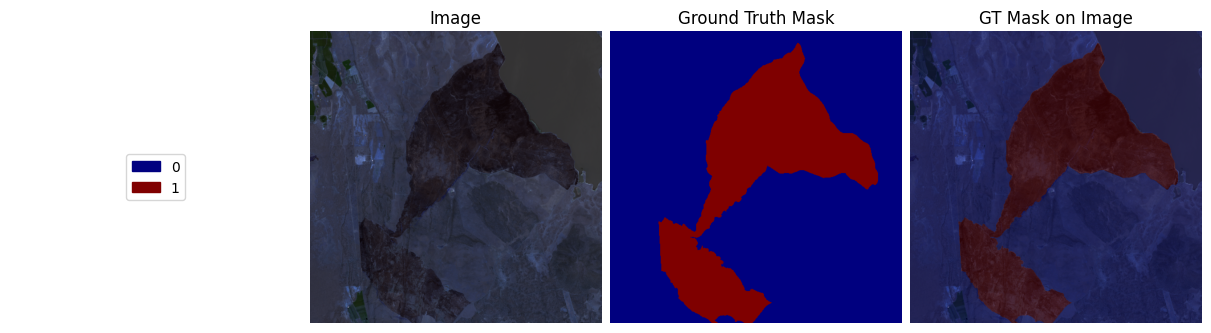

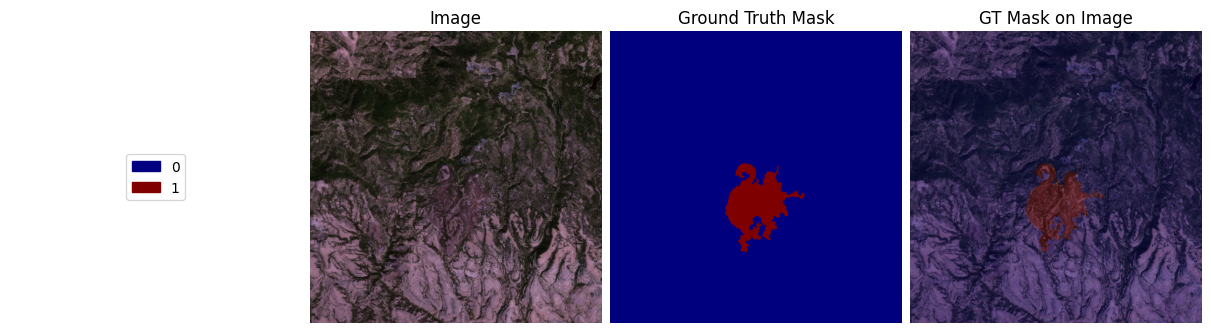

In [8]:
# plotting a few samples
val_dataset.plot(val_dataset[0])
val_dataset.plot(val_dataset[6])
val_dataset.plot(val_dataset[10])

In [9]:
# checking datasets testing split size
datamodule.setup("test")
test_dataset = datamodule.test_dataset
len(test_dataset)

120

# Fine-tune Prithvi

In [10]:
pl.seed_everything(0)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath="output/burnscars/checkpoints/",
    mode="max",
    monitor="val/Multiclass_Jaccard_Index", # Variable to monitor
    filename="best-{epoch:02d}",
)

# Lightning Trainer
trainer = pl.Trainer(
    accelerator="auto",
    strategy="auto",
    devices=1, # Deactivate multi-gpu because it often fails in notebooks
    precision='bf16-mixed',  # Speed up training
    num_nodes=1,
    logger=True,  # Uses TensorBoard by default
    max_epochs=3, # For demos
    log_every_n_steps=1,
    enable_checkpointing=True,
    callbacks=[checkpoint_callback, pl.callbacks.RichProgressBar()],
    default_root_dir="output/burnscars",
    detect_anomaly=True,
)

# Model
model = terratorch.tasks.SemanticSegmentationTask(
    model_factory="EncoderDecoderFactory",
    model_args={
        # Backbone
        "backbone": "prithvi_eo_v2_300", # Model can be either prithvi_eo_v1_100, prithvi_eo_v2_300, prithvi_eo_v2_300_tl, prithvi_eo_v2_600, prithvi_eo_v2_600_tl
        "backbone_pretrained": True,
        "backbone_num_frames": 1, # 1 is the default value,
        "backbone_img_size": 512,
        "backbone_bands": ["BLUE", "GREEN", "RED", "NIR_NARROW", "SWIR_1", "SWIR_2"],
        # "backbone_coords_encoding": [], # use ["time", "location"] for time and location metadata

        # Necks
        "necks": [
            {
                "name": "SelectIndices",
                # "indices": [2, 5, 8, 11] # indices for prithvi_eo_v1_100
                "indices": [5, 11, 17, 23] # indices for prithvi_eo_v2_300
                # "indices": [7, 15, 23, 31] # indices for prithvi_eo_v2_600
            },
            {"name": "ReshapeTokensToImage",},
            {"name": "LearnedInterpolateToPyramidal"}
        ],

        # Decoder
        "decoder": "UNetDecoder",
        "decoder_channels": [512, 256, 128, 64],

        # Head
        "head_dropout": 0.1,
        "num_classes": 2,
    },

    loss="ce",
    optimizer="AdamW",
    lr=1e-4,
    ignore_index=-1,
    freeze_backbone=True, # Only to speed up fine-tuning
    freeze_decoder=False,
    plot_on_val=True,
    class_names=['no burned', 'burned']  # optionally define class names
)

INFO: Seed set to 0
INFO:lightning.fabric.utilities.seed:Seed set to 0
INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:lightning.pytorch.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [11]:
trainer.fit(model, datamodule=datamodule)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model         │ PixelWiseModel   │  324 M │ train │
│ 1 │ criterion     │ CrossEntropyLoss │      0 │ train │
│ 2 │ train_metrics │ MetricCollection │      0 │ train │
│ 3 │ val_metrics   │ MetricCollection │      0 │ train │
│ 4 │ test_metrics  │ ModuleList       │      0 │ train │
└───┴───────────────┴──────────────────┴────────┴───────┘

Trainable params: 20.3 M                                                                                           
Non-trainable params: 303 M                                                                                        
Total params: 324 M                                                                                                
Total estimated model params size (MB): 1.3 K                                                                      
Modules in train mode: 617                                                                                         
Modules in eval mode: 0

Output()

INFO: `Trainer.fit` stopped: `max_epochs=3` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


In [12]:
!ls /content/output/burnscars/checkpoints/

'best-epoch=01.ckpt'


In [13]:
best_ckpt_path = "/content/output/burnscars/checkpoints/best-epoch=01.ckpt"

In [15]:
trainer = pl.Trainer(
    accelerator="auto",
    strategy="auto",
    devices=1, # Deactivate multi-gpu because it often fails in notebooks
    precision='bf16-mixed',  # Speed up training
    num_nodes=1,
    logger=True,  # Uses TensorBoard by default
    max_epochs=5, # Two iterations beyond the original configuration
    log_every_n_steps=1,
    enable_checkpointing=True,
    callbacks=[checkpoint_callback],#, pl.callbacks.RichProgressBar()],
    default_root_dir="output/burnscars",
    detect_anomaly=True,
)

trainer.fit(model, datamodule=datamodule, ckpt_path=best_ckpt_path)

INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:lightning.pytorch.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at /content/output/burnscars/checkpoints/best-epoch=01.ckpt
INFO:lightning.pytorch.utilities.

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
